In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple as nt

In [ ]:
Data = nt("Data", "x_train y_train x_valid y_valid x_test y_test")

In [ ]:
def visualize_data(data):
    images_to_show = 36
    per_row = 12
    fig = plt.figure(figsize=(20,5))
    for i in range(images_to_show):
        pos = (i // per_row, ((i % per_row) + per_row) % per_row)
        ax = plt.subplot2grid((int(images_to_show / per_row), per_row),
                              pos, xticks=[], yticks=[])
        ax.imshow(np.squeeze(data.x_train[i]))
    plt.show()

In [ ]:
def visualize_training(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.show()
    
    # A chart showing our training vs validation loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.datasets import cifar10

In [ ]:
def preprocess(data, categories):
    x_train = data.x_train.astype("float32") / 255
    x_test = data.x_test.astype("float32") / 255
    y_train = to_categorical(data.y_train, categories)
    y_test = to_categorical(data.y_test, categories)    
    return Data(x_train[5000:], y_train[5000:],
                x_train[:5000], y_train[:5000],
                x_test, y_test)


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
data = Data(x_train, y_train, None, None, x_test, y_test)

In [ ]:
categories = len(np.unique(data.y_train))
print("Shape of x_train pre-processing: ", data.x_train.shape)
print("Shape of y_train pre-processing: ", data.y_train.shape)
processed_data = preprocess(data, categories)
print("Shape of x_train post-processing: ", processed_data.x_train.shape)
print("Shape of y_train post-processing: ", processed_data.y_train.shape)
print("Shape of x_valid post-processing: ", processed_data.x_valid.shape)
print("Shape of y_valid post-processing: ", processed_data.y_valid.shape)
print("Shape of x_test post-processing: ", processed_data.x_test.shape)
print("Shape of y_test post-processing: ", processed_data.y_test.shape)

Shape of x_train pre-processing:  (50000, 32, 32, 3)
Shape of y_train pre-processing:  (50000, 1)
Shape of x_train post-processing:  (45000, 32, 32, 3)
Shape of y_train post-processing:  (45000, 10)
Shape of x_valid post-processing:  (5000, 32, 32, 3)
Shape of y_valid post-processing:  (5000, 10)
Shape of x_test post-processing:  (10000, 32, 32, 3)
Shape of y_test post-processing:  (10000, 10)


In [ ]:

def build_cnn(data, categories):
    # Create model architecture
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding="same", activation="relu",
                     input_shape=data.x_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(500, activation="relu"))
    model.add(Dropout(0.4))
    model.add(Dense(categories, activation="softmax"))
    
    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop",
                  metrics=["accuracy"])
    return model

In [ ]:
cnn = build_cnn(processed_data, categories)
print("CNN architecture:")
cnn.summary()

CNN architecture:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4,

In [ ]:
cnn_weights_path = "saved_weights/cifar10_cnn_best.hdf5"

In [ ]:
checkpointer_cnn = ModelCheckpoint(cnn_weights_path, verbose=1, save_best_only=True)
hist_cnn = cnn.fit(processed_data.x_train, processed_data.y_train, batch_size=32, 
                   epochs=20, validation_data=(processed_data.x_valid, 
                                               processed_data.y_valid),
                   callbacks=[checkpointer_cnn])


Epoch 1/20
1407/1407 [==============================] - 39s 11ms/step - loss: 1.5925 - accuracy: 0.4209 - val_loss: 1.3229 - val_accuracy: 0.5234

Epoch 00001: val_loss improved from inf to 1.32290, saving model to saved_weights\cifar10_cnn_best.hdf5
Epoch 2/20
1407/1407 [==============================] - 19s 13ms/step - loss: 1.2713 - accuracy: 0.5453 - val_loss: 1.1804 - val_accuracy: 0.5958

Epoch 00002: val_loss improved from 1.32290 to 1.18045, saving model to saved_weights\cifar10_cnn_best.hdf5
Epoch 3/20
1407/1407 [==============================] - 19s 13ms/step - loss: 1.1479 - accuracy: 0.5965 - val_loss: 1.0344 - val_accuracy: 0.6398

Epoch 00003: val_loss improved from 1.18045 to 1.03445, saving model to saved_weights\cifar10_cnn_best.hdf5
Epoch 4/20
1407/1407 [==============================] - 23s 16ms/step - loss: 1.0820 - accuracy: 0.6209 - val_loss: 1.2568 - val_accuracy: 0.5842

Epoch 00004: val_loss did not improve from 1.03445
Epoch 5/20
1407/1407 [===================

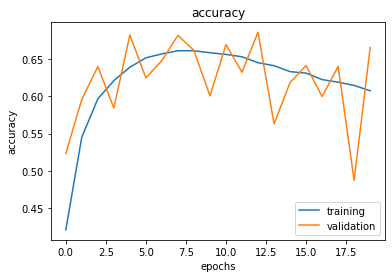

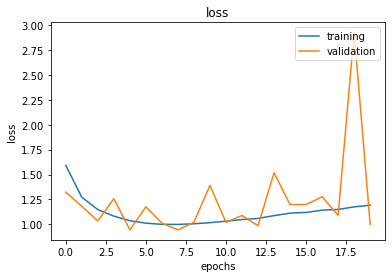

In [ ]:
visualize_training(hist_cnn)


In [ ]:
import tensorflow as tf
tf.__version__

'2.6.0-dev20210618'

In [ ]:
cnn.load_weights(cnn_weights_path)
score_cnn = cnn.evaluate(processed_data.x_test, processed_data.y_test, verbose=0)

In [ ]:
print("Accuracy cnn: {0:.2f}%".format(score_cnn[1] * 100))

Accuracy cnn: 66.99%


In [ ]:
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [ ]:
def optimized_preprocess(data, categories):
    # Z-score normalization of data
    mean = np.mean(data.x_train, axis=(0,1,2,3))
    std = np.std(data.x_train, axis=(0,1,2,3))
    x_train = ((data.x_train - mean) / (std + 1e-7)).astype("float32")
    x_test = ((data.x_test - mean) / (std + 1e-7)).astype("float32")
    y_train = to_categorical(data.y_train, categories)
    y_test = to_categorical(data.y_test, categories)    
    return Data(x_train[5000:], y_train[5000:],
                x_train[:5000], y_train[:5000],
                x_test, y_test)

In [ ]:
def learningrate_schedule(epoch):
    # We use a standard learning rate of 0.001
    # From the 51st epoch, we decrease it to 0.0007
    # From the 101st epoch, we decrease it further to 0.0005
    # From the 1356h epoch, we decrease it further to 0.0003
    # From the 176th epoch, we decrease it further to 0.0001
    rate = 0.001
    if epoch > 175:
        rate = 0.0001
    elif epoch > 135:
        rate = 0.0003
    elif epoch > 100:
        rate = 0.0005
    elif epoch > 50:
        rate = 0.0007    
    return rate

In [ ]:
def build_optimized_cnn(data, categories):
    weight_decay = 1e-4
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, padding="same", activation="elu",
                     kernel_regularizer=regularizers.l2(weight_decay), input_shape=data.x_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=3, padding="same", activation="elu",
                     kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=3, padding="same", activation="elu",
                     kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=3, padding="same", activation="elu",
                     kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=3, padding="same", activation="elu",
                     kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=3, padding="same", activation="elu",
                     kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(categories, activation="softmax"))

    optimized_rmsprop = RMSprop(lr=0.001,decay=1e-6)
    model.compile(loss="categorical_crossentropy", optimizer=optimized_rmsprop,
                  metrics=["accuracy"])
    return model


In [ ]:
optimized_processed_data = optimized_preprocess(data, categories)

In [ ]:
# Build optimized cnn
optimized_cnn = build_optimized_cnn(optimized_processed_data, categories)
print("Optimized CNN architecture:")
optimized_cnn.summary()

Optimized CNN architecture:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)         

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
# Perform data augmentation
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.15,
                             height_shift_range=0.15, horizontal_flip=True)
datagen.fit(optimized_processed_data.x_train)

In [ ]:
# Train the optimized cnn
batch_size = 64
optimized_cnn_path_best = "saved_weights/optimized_cifar10_cnn_best.hdf5"
checkpointer_optimized_cnn = ModelCheckpoint(optimized_cnn_path_best, verbose=1, 
                                             save_best_only=True)
hist_optimized_cnn = optimized_cnn.fit_generator(datagen.flow(optimized_processed_data.x_train, 
    optimized_processed_data.y_train, batch_size=batch_size), 
    steps_per_epoch=optimized_processed_data.x_train.shape[0] // batch_size, epochs=250,
    verbose=0, validation_data= (optimized_processed_data.x_valid,
    optimized_processed_data.y_valid), callbacks=[checkpointer_optimized_cnn,
    LearningRateScheduler(learningrate_schedule), EarlyStopping(min_delta=0.001, 
    patience=40)])

optimized_cnn.load_weights(optimized_cnn_path_best)
score_optimized_cnn = optimized_cnn.evaluate(optimized_processed_data.x_test, 
                                             optimized_processed_data.y_test, verbose=0)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:1976: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '



Epoch 00001: val_loss improved from inf to 1.91345, saving model to saved_weights\optimized_cifar10_cnn_best.hdf5

Epoch 00002: val_loss improved from 1.91345 to 1.51136, saving model to saved_weights\optimized_cifar10_cnn_best.hdf5

Epoch 00003: val_loss improved from 1.51136 to 0.96289, saving model to saved_weights\optimized_cifar10_cnn_best.hdf5

Epoch 00004: val_loss improved from 0.96289 to 0.89797, saving model to saved_weights\optimized_cifar10_cnn_best.hdf5

Epoch 00005: val_loss did not improve from 0.89797

Epoch 00006: val_loss did not improve from 0.89797

Epoch 00007: val_loss improved from 0.89797 to 0.80182, saving model to saved_weights\optimized_cifar10_cnn_best.hdf5

Epoch 00008: val_loss improved from 0.80182 to 0.73349, saving model to saved_weights\optimized_cifar10_cnn_best.hdf5

Epoch 00009: val_loss did not improve from 0.73349

Epoch 00010: val_loss did not improve from 0.73349

Epoch 00011: val_loss improved from 0.73349 to 0.67067, saving model to saved_wei

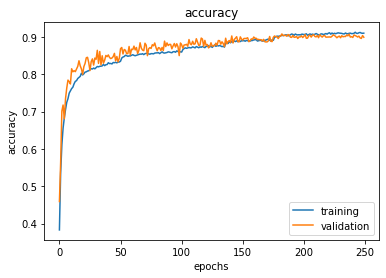

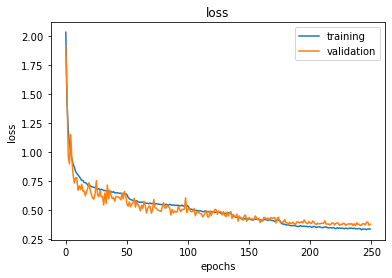

In [ ]:
visualize_training(hist_optimized_cnn)

In [ ]:
print("Accuracy optimized cnn: {0:.2f}%".format(score_optimized_cnn[1] * 100))

Accuracy optimized cnn: 89.97%
